# **Klasyfikacja za pomocą naiwnej metody bayesowskiej z rozkładem normalnym**

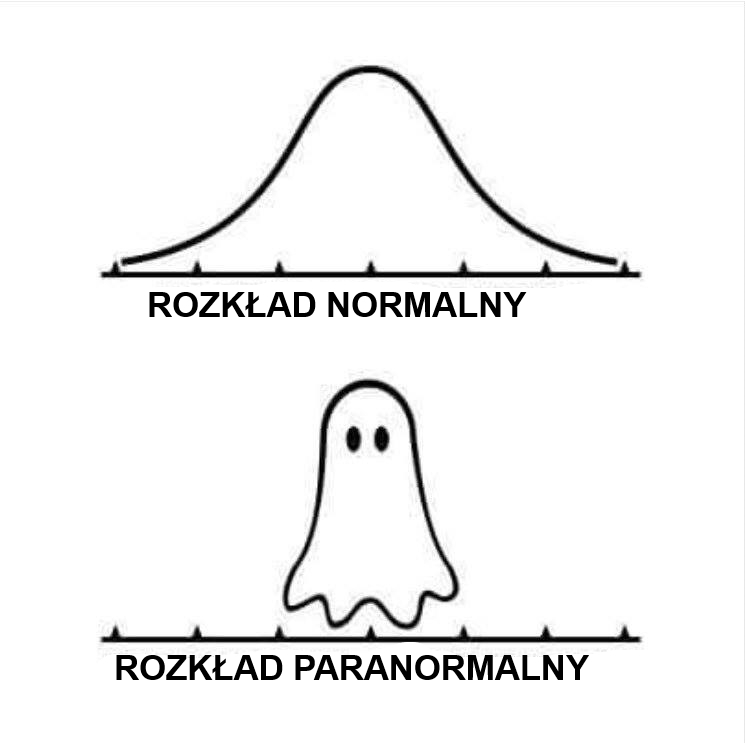

# **Twierdzenie Bayesa**
bayes.svg

P(A) -- oznacza prawdopodobieństwo a-priori wystąpienia klasy A (tj. prawdopodobieństwo, że dowolny przykład należy do klasy A)

P(B|A) -- oznacza prawdopodobieństwo a-posteriori, że B należy do 
klasy A

P(B) -- znacza prawdopodobieństwo a-priori wystąpienia przykładu B 

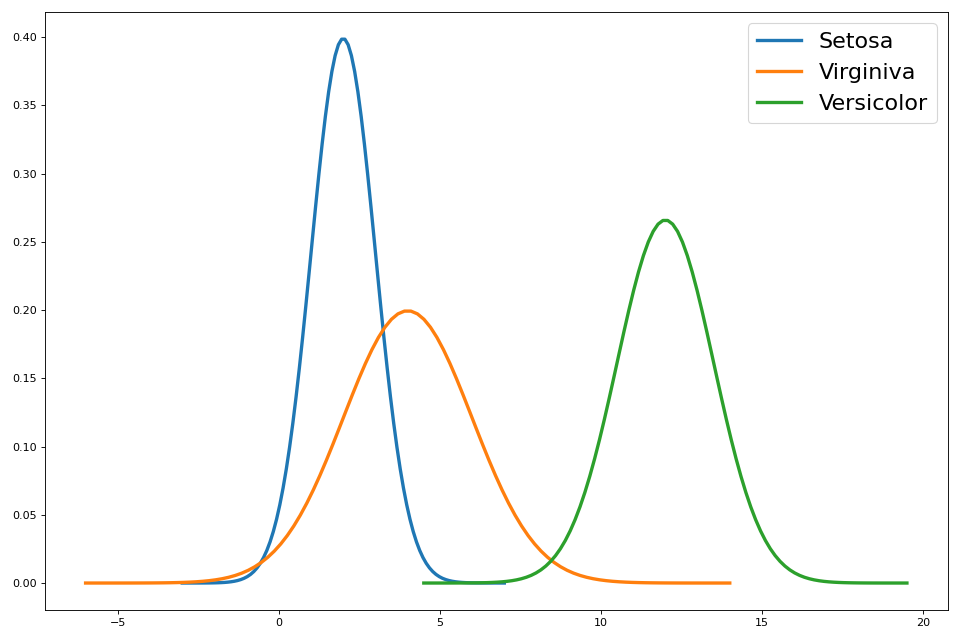

# Funkcja gęstości prawdopodobieństwa rozkładu normalnego 
gestosc.svg

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set(style="whitegrid")

In [2]:
class NaiveBayesClassifier():
    def calc_prior(self, features, target):
        '''
        Wyliczenie prawdopodobieństwa a priori
        '''
        self.prior = (features.groupby(target).apply(lambda x: len(x)) / self.rows).to_numpy()

        return self.prior
    
    def calc_statistics(self, features, target):
        '''
        Wyliczenie średnich i wariancji dla danych
        ''' 
        self.mean = features.groupby(target).apply(np.mean).to_numpy()
        self.var = features.groupby(target).apply(np.var).to_numpy()
              
        return self.mean, self.var
    
    def gaussian_density(self, class_idx, x):     
        '''
        Wyliczenie prawdopodobieństwa z rozkładu normalnego        
        (1/√2pi*σ) * exp((-1/2)*((x-μ)^2)/(2*σ²))
        μ -średnia
        σ² - wariancja
        σ - odchylenie standardowe
        '''
        mean = self.mean[class_idx]
        var = self.var[class_idx]
        
        numerator = np.exp((-1/2)*((x-mean)**2) / (2 * var)) # Licznik wzoru na gęstość rozkładu normalnego 
        denominator = np.sqrt(2 * np.pi * var) # Mianownik wzoru na gęstość rozkładu normalnego 
        prob = numerator / denominator
        
        return prob
    
    def classify(self, x):
        '''
        Wyliczenie prawdopodobieństwa a posteriori i zwrócenie klasy, dla której prawdopodobieństwo jest najwyższe
        '''
        posteriors = []
        posteriors_no_log = []

        # calculate posterior probability for each class
        for i in range(self.count):
            prior = np.log(self.prior[i]) # Do predykcji używane jest prawodopodobieństwo logarytmiczne
            prior_no_log = self.prior[i] # Zwykłe prawdopodobieństwo liczymy, żeby zwrócić je z predykcjami

            conditional = np.sum(np.log(self.gaussian_density(i, x))) 
            conditional_no_log = np.prod(self.gaussian_density(i, x))

            posterior = prior + conditional
            posterior_no_log = prior_no_log * conditional_no_log

            posteriors.append(posterior)
            posteriors_no_log.append(posterior_no_log)

        # Zwracamy klasę o największym prawdopodobieństwie
        return self.classes[np.argmax(posteriors)], np.max(posteriors_no_log)

    def fit(self, features, target):
        '''
        Główna metoda trenująca model
        '''
        self.classes = np.unique(target)
        self.count = len(self.classes)
        self.feature_nums = features.shape[1]
        self.rows = features.shape[0]
        
        self.calc_statistics(features, target)
        self.calc_prior(features, target)
        
    def predict(self, features):
        '''
        Predykcja wartości dla każdego wiersza
        '''
        preds = [self.classify(f) for f in features.to_numpy()]
        return preds

    def accuracy(self, y_test, y_pred):
        '''
        Wyliczenie accuracy modelu
        '''
        accuracy = np.sum(y_test == y_pred) / len(y_test)
        return accuracy

    def visualize(self, y_true, y_pred, target):
        '''
        Narysowanie wykresu porównującego rozkład klas prawdziwych i przewidzianych
        '''
        tr = pd.DataFrame(data=y_true, columns=[target])
        pr = pd.DataFrame(data=y_pred, columns=[target])
        
        
        fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15,6))
        
        sns.countplot(x=target, data=tr, ax=ax[0], alpha=0.7, hue=target, dodge=False)
        sns.countplot(x=target, data=pr, ax=ax[1], alpha=0.7, hue=target, dodge=False)
        
        ax[0].tick_params(labelsize=12)
        ax[1].tick_params(labelsize=12)
        ax[0].set_title("Prawdziwe wartości", fontsize=18)
        ax[1].set_title("Predykcje", fontsize=18)
        plt.show()


### Pitność wody

In [3]:
# Preprocessing danych

# Uzupełnienie pustych wartości w kolumnach
def fill_nan(df):
    for index, column in enumerate(df.columns[:9]):
        df[column] = df[column].fillna(df.groupby('Potability')[column].transform('mean'))
    return df

# Wczytywanie danych
df = pd.read_csv("water_potability.csv")

df = fill_nan(df)

# Zrandomizowanie kolejności danych w datasecie
df = df.sample(frac=1, random_state=10).reset_index(drop=True)

# Podział na atrybuty i przewidywane wartości
X, y = df.iloc[:, :-1], df.iloc[:, -1]

# Normalizacja i skalowanie danych
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X.to_numpy())
X = pd.DataFrame(X, columns=df.columns.values.tolist()[:-1])

# Podział na dane trenujące i testowe, z uwzględnieniem równego rozłożenia danych
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2948, 9) (2948,)
(328, 9) (328,)


In [4]:
X_train

ph  Hardness    Solids  Chloramines   Sulfate  Conductivity  \
1022  0.003078  0.688791  0.846257     1.428934 -0.858263      0.002792   
3191 -0.587365  0.223203 -0.731867     0.397503  0.759893      0.330607   
13    0.003078 -0.241037  0.773051     0.580019  1.334369     -0.049130   
2068 -2.176058  1.443006 -1.626771    -4.164610 -0.033706     -1.050763   
1484  0.213047  0.403036 -0.464729     0.070417  0.021560     -0.952776   
...        ...       ...       ...          ...       ...           ...   
691   0.003078  1.199106 -0.003483    -0.670308 -0.069513      0.185754   
1283 -2.034004 -1.508135  0.255310     0.083839 -1.413707      0.694074   
2818 -0.702987 -0.575677  0.755056     0.664695  0.021560     -0.489334   
1330  1.525943  0.497074 -0.714355    -1.024237 -1.022037     -0.327074   
1926 -0.043558 -0.882359 -0.456141    -0.770271  0.795189      0.560306   

      Organic_carbon  Trihalomethanes  Turbidity  
1022        0.913790         0.232417   2.319505  
3191        0.094379         0.282563   0.235024  
13         -1.121422        -0.200432  -0.946356  
2068       -0.391328        -0.398649  -0.298341  
1484       -0.213330         0.111419  -0.235893  
...              ...              ...        ...  
691        -0.466010         0.031975   0.676276  
1283       -1.110579         0.232996   2.544703  
2818        0.371852        -2.272990  -1.764684  
1330       -1.107341         0.517432  -1.230528  
1926       -1.086081        -1.356820   0.172521  

[2948 rows x 9 columns]

In [5]:
# Trenowanie modelu klasyfikatora
x = NaiveBayesClassifier()
x.fit(X_train, y_train)

/home/andrzej/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [6]:
# Predykcja wartości dla danych testowych
predictions = x.predict(X_test)

# Prawdopodobieństwa kolejnych predykcji
probabilities = [p[1] for p in predictions]

# Przewidziana wartość
predictions = [p[0] for p in predictions]
predictions[0]

0

In [7]:
# Wyliczenie accuracy modelu
x.accuracy(y_test, predictions)

6.280487804878049e-01

In [8]:
from sklearn.metrics import f1_score

f1_score(y_test, predictions)

0.14084507042253522

In [9]:
y_test.value_counts(normalize=True)

0    0.609756
1    0.390244
Name: Potability, dtype: float64

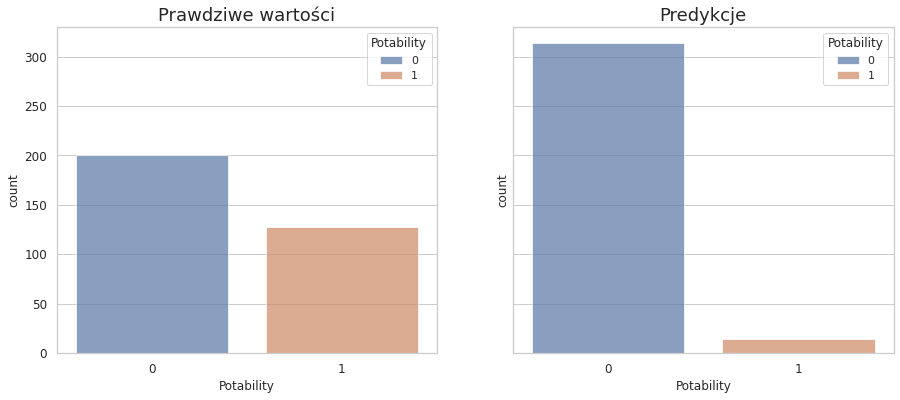

In [10]:
x.visualize(y_test, predictions, 'Potability')

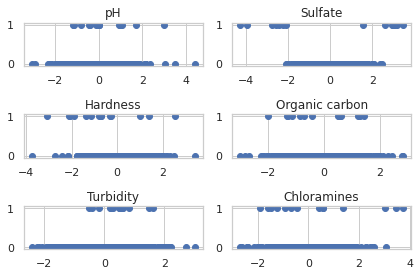

In [11]:
ph_val = X_test["ph"]
sulfate_val = X_test["Sulfate"]
hard_val = X_test["Hardness"]
carb_val = X_test["Organic_carbon"]
turb_val = X_test["Turbidity"]
ch_val = X_test["Chloramines"]


figure, axes = plt.subplots(nrows=3, ncols=2)

axes[0, 0].plot(ph_val, predictions, 'bo')
axes[0, 0].set_title("pH")

axes[0, 1].plot(sulfate_val, predictions, 'bo')
axes[0, 1].set_title("Sulfate")

axes[1, 0].plot(hard_val, predictions, 'bo')
axes[1, 0].set_title("Hardness")

axes[1, 1].plot(carb_val, predictions, 'bo')
axes[1, 1].set_title("Organic carbon")

axes[2, 0].plot(turb_val, predictions, 'bo')
axes[2, 0].set_title("Turbidity")

axes[2, 1].plot(ch_val, predictions, 'bo')
axes[2, 1].set_title("Chloramines")

figure.tight_layout()
plt.show()

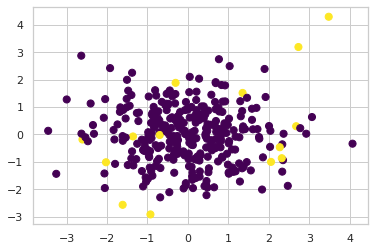

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_test)
X_pca = pca.transform(X_test)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predictions, s=50, cmap='viridis')

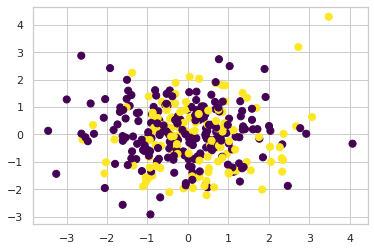

In [13]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_test, s=50, cmap='viridis')

### Irysy

In [14]:
# Preprocessing danych


# Wczytywanie danych
df = pd.read_csv("iris.csv")

# Zrandomizowanie kolejności danych w datasecie
df = df.sample(frac=1, random_state=10).reset_index(drop=True)

# Podział na atrybuty i przewidywane wartości
X, y = df.iloc[:, :-1], df.iloc[:, -1]

# Normalizacja i skalowanie danych
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X.to_numpy())
X = pd.DataFrame(X, columns=df.columns.values.tolist()[:-1])

# Podział na dane trenujące i testowe, z uwzględnieniem równego rozłożenia danych
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


# Trenowanie modelu klasyfikatora
x = NaiveBayesClassifier()
x.fit(X_train, y_train)


# Predykcja wartości dla danych testowych
predictions = x.predict(X_test)

# Prawdopodobieństwa kolejnych predykcji
probabilities = [p[1] for p in predictions]

# Przewidziana wartość
predictions = [p[0] for p in predictions]


# Wyliczenie accuracy modelu
print(x.accuracy(y_test, predictions))

(105, 4) (105,)
(45, 4) (45,)
9.333333333333333e-01


/home/andrzej/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [15]:
f1_score(y_test, predictions, average="macro")

0.9326599326599326

     sepal.length  sepal.width  petal.length  petal.width
106     -0.900681     0.558611     -1.169714    -0.920548
65      -1.143017     1.249201     -1.340227    -1.447076
49       1.038005     0.558611      1.103783     1.712096
74       2.128516    -0.131979      1.615320     1.185567
110     -0.173674     1.709595     -1.169714    -1.183812
..            ...          ...           ...          ...
123     -1.021849    -0.131979     -1.226552    -1.315444
121     -0.052506    -1.052767      0.137547     0.000878
85      -0.537178     1.939791     -1.169714    -1.052180
13      -1.143017    -0.131979     -1.340227    -1.315444
125     -1.870024    -0.131979     -1.510739    -1.447076

[105 rows x 4 columns]


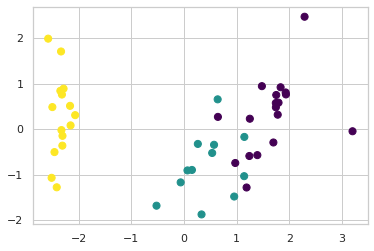

In [18]:
pca = PCA(n_components=2)
pca.fit(X_test)
X_pca = pca.transform(X_test)

df_pred = pd.DataFrame(predictions).replace({'Virginica': 0, 'Versicolor': 1, "Setosa": 2}, regex=True)
df_pred = np.array(df_pred).reshape(1, -1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_pred[0], s=50, cmap='viridis')

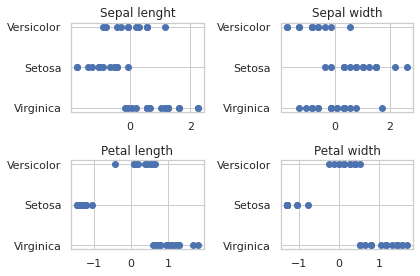

In [19]:
sep_len = X_test["sepal.length"]
sep_with = X_test["sepal.width"]
pet_len = X_test["petal.length"]
pet_with = X_test["petal.width"]

figure, axes = plt.subplots(nrows=2, ncols=2)

axes[0, 0].plot(sep_len, predictions, 'bo')
axes[0, 0].set_title("Sepal lenght")

axes[0, 1].plot(sep_with, predictions, 'bo')
axes[0, 1].set_title("Sepal width")

axes[1, 0].plot(pet_len, predictions, 'bo')
axes[1, 0].set_title("Petal length")

axes[1, 1].plot(pet_with, predictions, 'bo')
axes[1, 1].set_title("Petal width")

figure.tight_layout()
plt.show()